# Variables

In [2]:
sigma_Q=1
sigma_px=30
sigma_py=30

T_e=1
T=100
F=np.array([[1,T_e,0,0],[0,1,0,0],[0,0,1,T_e],[0,0,0,1]])
Q=sigma_Q*np.array([[T_e**3/3,T_e**2/2,0,0],[T_e**2/2,T_e,0,0],[0,0,T_e**3/3,T_e**2/2],[0,0,T_e**2,T_e]])
H=np.array([[1,0,0,0],[0,0,1,0]])
R=np.array([[sigma_px**2,0],[0,sigma_py**2]])

x_init=np.array([[3],[40],[-4],[20]])
x_kalm=x_init
P_kalm=np.identity(4)

# Fonctions

In [3]:
def creer_trajectoire(F=F,Q=Q,x_init=x_init,T=T):
    x=x_init
    vecteur_x=np.zeros((4,T))
    vecteur_x[:,0]=x_init.reshape((4,))
    for n in range(1,T):
        U=np.random.multivariate_normal([0,0,0,0],Q).reshape((4,1))
        x=F@x+U
        vecteur_x[:,n]=x.reshape((4,))
    return vecteur_x
vecteur_x=creer_trajectoire()

/tmp/ipykernel_2793123/1551965814.py:6: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  U=np.random.multivariate_normal([0,0,0,0],Q).reshape((4,1))


In [4]:
def creer_observation(vecteur_x,H=H,R=R,T=T):
    vecteur_y=np.zeros((2,T))
    for n in range(T):
        x=vecteur_x[:,n]
        V=np.random.multivariate_normal([0,0],R).reshape((2,1))
        y=H@x+V.T
        vecteur_y[:,n]=y.reshape((2,))
    return vecteur_y

In [5]:
def filtre_de_kalman(y_k,x_kalm_prec,P_kalm_prec,F=F,Q=Q,H=H,R=R):
    y_k=y_k.reshape((2,1))
    x_kalm=F@x_kalm_prec
    #print(x_kalm.shape)
    P_kalm=F@P_kalm_prec@F.T + Q
    #print(P_kalm.shape)
    temp=H@P_kalm@H.T+R
    temp=np.linalg.inv(temp)
    K=P_kalm@H.T@temp
    #print(K.shape)
    P_kalm_k=(np.identity(4) - K@H)@P_kalm
    #print(P_kalm_k.shape)
    x_kalm_k=x_kalm+K@(y_k-H@x_kalm)
    #print(x_kalm_k)
    return x_kalm_k,P_kalm_k

In [6]:
def filtre_de_kalman_v2(y_k1,x_kalm_k_k,P_kalm_k_k,F=F,Q=Q,H=H,R=R):
    x_kalm_k1_k = F @ x_kalm_k_k # Calcule m k=1 sachant k
    P_kalm_k1_k = (F @ P_kalm_k_k @ F.T) + Q
    
    # Si il n'y a pas d'observation on renvois l'estimateur k+1 sachant k
    if False: # y_k1 == ["NaN", "NaN"]:
        return x_kalm_k1_k
    # Sinon on continue !
    y_k1 = y_k1.reshape((2,1)) # Nouelle abservation
    
    K = P_kalm_k1_k @ H.T @ np.linalg.inv((H @ P_kalm_k1_k @ H.T) + R)
    
    # print(x_kalm_k1_k.shape)
    # print((H @ x_kalm_k1_k).shape, np.identity(4).shape, K.shape)
    
    x_kalm_k1_k1 = x_kalm_k1_k + K @ (y_k1 - (H @ x_kalm_k1_k))
    P_kalm_k1_k1 = (np.identity(4) - K@H) @ P_kalm_k1_k
    

    return x_kalm_k1_k1, P_kalm_k1_k1

In [7]:
def kalman_recursif(vecteur_y,vecteur_y0,x_kalm=x_kalm,P_kalm=P_kalm,T=T):
    x_est=np.zeros((4,T))
    x_est[:,0]=x_kalm.reshape((4,))
    for n in range(1,T):
        x_kalm,P_kalm=filtre_de_kalman(vecteur_y[:,n],x_kalm,P_kalm)
        x_est[:,n]=x_kalm.reshape((4,))
    return x_est

In [4]:
def coordinate(px,py):
    r=np.sqrt(px**2+py**2)
    theta=np.arctan(py/px)
    return r,theta

# Main

In [8]:
vecteur_x=creer_trajectoire()
vecteur_y=creer_observation(vecteur_x)
x_est=kalman_recursif(vecteur_y,x_init)

/tmp/ipykernel_2793123/1551965814.py:6: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  U=np.random.multivariate_normal([0,0,0,0],Q).reshape((4,1))


In [9]:
err_quadra = np.zeros(T)
for t in range(T):
    err_quadra[t] = ((vecteur_x[:, t] - x_est[:, t]).T)@(vecteur_x[:, t] - x_est[:, t])

erreur_moyenne = (1/T) * np.sum(np.sqrt(err_quadra))
print('erreur moyenne = ', erreur_moyenne)

erreur moyenne =  16.276463074536057


In [10]:
dfx=pd.DataFrame(vecteur_x.T,columns=['px','px.','py','py.'])
dfy=pd.DataFrame(vecteur_y.T,columns=['Opx','Opy'])
dfest=pd.DataFrame(x_est.T,columns=['Estpx','Estpx.','Estpy','Estpy.'])
dferr=pd.DataFrame(err_quadra,columns=["err_quadra"])
df=pd.concat([dfx,dfy,dfest,dferr],axis=1)
df.to_csv('Results4/Data/sigma_Q='+ str(sigma_Q) + '-sigma_px=' +str(sigma_px)+ '-sigma_py=' +str(sigma_py)+'.csv')

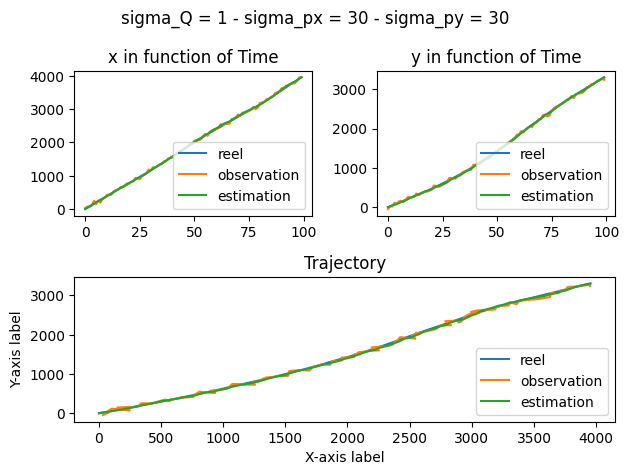

In [11]:
ax1=plt.subplot(212)
ax1.plot(df['px'], df['py'], label='reel')
ax1.plot(df['Opx'], df['Opy'], label='observation')
ax1.plot(df['Estpx'], df['Estpy'], label='estimation')
ax1.set_xlabel('X-axis label')
ax1.set_ylabel('Y-axis label')
ax1.set_title('Trajectory')
ax1.legend(loc="lower right") 

ax2=plt.subplot(221)
ax2.plot(df['px'], label='reel')
ax2.plot(df['Opx'],  label='observation')
ax2.plot(df['Estpx'],  label='estimation')
ax2.set_title('x in function of Time')
ax2.legend(loc="lower right")

ax3=plt.subplot(222)
ax3.plot(df['py'], label='reel')
ax3.plot(df['Opy'],  label='observation')
ax3.plot(df['Estpy'],  label='estimation')
ax3.set_title('y in function of Time')
ax3.legend(loc="lower right")

plt.suptitle('sigma_Q = '+ str(sigma_Q) + ' - sigma_px = ' +str(sigma_px)+ ' - sigma_py = ' +str(sigma_py))
plt.tight_layout()
# Show the plot
plt.savefig('Results4/Figures/sigma_Q='+ str(sigma_Q) + '-sigma_px=' +str(sigma_px)+ '-sigma_py=' +str(sigma_py)+'.png')
plt.show()

In [5]:
coordinate(10,10)

(14.142135623730951, 0.7853981633974483)